<a href="https://colab.research.google.com/github/su763/COVID-19/blob/main/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import warnings

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from google.colab import files

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [11]:
print("Please select your files to upload...")
uploaded = files.upload()

Please select your files to upload...


Saving usa_county_wise.csv to usa_county_wise.csv
Saving worldometer_data.csv to worldometer_data.csv
Saving country_wise_latest.csv to country_wise_latest (1).csv
Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv
Saving day_wise.csv to day_wise.csv
Saving full_grouped.csv to full_grouped.csv


In [32]:
df_country_wise = pd.read_csv('country_wise_latest.csv')
df_clean_complete = pd.read_csv('covid_19_clean_complete.csv')
df_day_wise = pd.read_csv('day_wise.csv')
# df_full_grouped = pd.read_csv('full_grouped.csv')
# df_usa_county = pd.read_csv('usa_county_wise.csv')
df_worldometer = pd.read_csv('worldometer_data.csv')

print("\nAll files are uploaded and ready to be read into DataFrames.")


All files are uploaded and ready to be read into DataFrames.


In [16]:
print("\n--- Original Data Info for df_country_wise ---")
df_country_wise.info()
print(df_country_wise.head())

print("\n--- Original Data Info for df_clean_complete ---")
df_clean_complete.info()
print(df_clean_complete.head())


--- Original Data Info for df_country_wise ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country/Region          187 non-null    object 
 1   Confirmed               187 non-null    int64  
 2   Deaths                  187 non-null    int64  
 3   Recovered               187 non-null    int64  
 4   Active                  187 non-null    int64  
 5   New cases               187 non-null    int64  
 6   New deaths              187 non-null    int64  
 7   New recovered           187 non-null    int64  
 8   Deaths / 100 Cases      187 non-null    float64
 9   Recovered / 100 Cases   187 non-null    float64
 10  Deaths / 100 Recovered  187 non-null    float64
 11  Confirmed last week     187 non-null    int64  
 12  1 week change           187 non-null    int64  
 13  1 week % increase       187 non-null    float64

In [18]:
print("\n--- Starting Preprocessing ---")

# Let's see what's missing
print("\nMissing values before cleaning for df_country_wise:")
print(df_country_wise.isnull().sum())

print("\nMissing values before cleaning for df_clean_complete:")
print(df_clean_complete.isnull().sum())


--- Starting Preprocessing ---

Missing values before cleaning for df_country_wise:
Country/Region            0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
New cases                 0
New deaths                0
New recovered             0
Deaths / 100 Cases        0
Recovered / 100 Cases     0
Deaths / 100 Recovered    0
Confirmed last week       0
1 week change             0
1 week % increase         0
WHO Region                0
dtype: int64

Missing values before cleaning for df_clean_complete:
Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64


In [21]:
# -------------------------------------------------------------------
# PART 1: GLOBAL TIME SERIES ANALYSIS (day_wise.csv)
# -------------------------------------------------------------------
print("\n--- PART 1: GLOBAL TIME SERIES ANALYSIS ---")
print("Analyzing global trends over time...")

# Preprocessing: Convert Date
df_day_wise['Date'] = pd.to_datetime(df_day_wise['Date'])


--- PART 1: GLOBAL TIME SERIES ANALYSIS ---
Analyzing global trends over time...


Saved 'global_cumulative_cases.png'


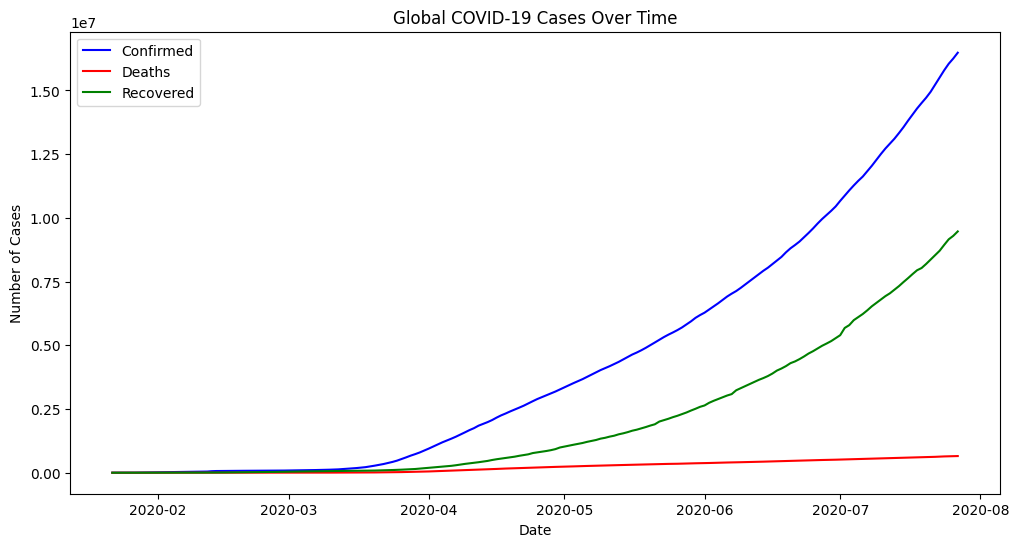

In [24]:
# Visualization 1: Cumulative Cases Over Time
plt.figure(figsize=(12, 6))
plt.plot(df_day_wise['Date'], df_day_wise['Confirmed'], label='Confirmed', color='blue')
plt.plot(df_day_wise['Date'], df_day_wise['Deaths'], label='Deaths', color='red')
plt.plot(df_day_wise['Date'], df_day_wise['Recovered'], label='Recovered', color='green')
plt.title('Global COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.savefig('global_cumulative_cases.png')
print("Saved 'global_cumulative_cases.png'")

In [28]:
# Set plot styles
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


Saved 'global_daily_new_cases.png'


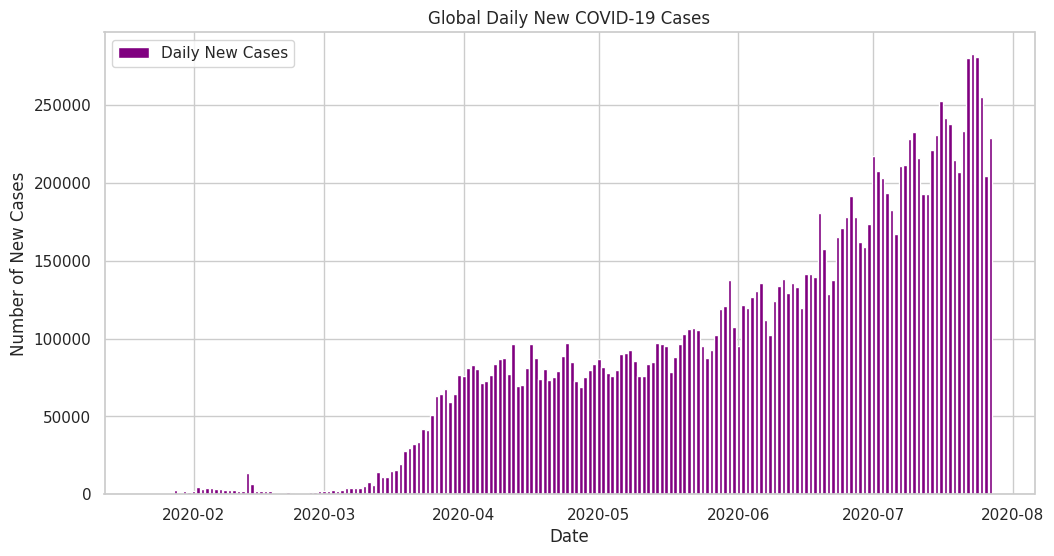

In [30]:
# Visualization 2: Daily New Cases
plt.figure(figsize=(12, 6))
plt.bar(df_daywise['Date'], df_daywise['New cases'], label='Daily New Cases', color='purple')
plt.title('Global Daily New COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.legend()
plt.savefig('global_daily_new_cases.png')
print("Saved 'global_daily_new_cases.png'")

In [33]:
# PART 2: PREDICTIVE MODELING (worldometer_data.csv)
# -------------------------------------------------------------------
print("\n--- PART 2: PREDICTIVE MODELING & EDA ---")
print("Analyzing country-level data to predict Total Deaths...")

# --- Preprocessing ---
print("Preprocessing 'worldometer_data.csv'...")

# Drop columns with too many NaNs or that are not predictive
df_world_processed = df_worldometer.drop([
    'NewCases', 'NewDeaths', 'NewRecovered', 'Country/Region'
], axis=1)


--- PART 2: PREDICTIVE MODELING & EDA ---
Analyzing country-level data to predict Total Deaths...
Preprocessing 'worldometer_data.csv'...


In [34]:
# Define columns for imputation and transformation
numeric_features = df_world_processed.select_dtypes(include=np.number).columns.drop('TotalDeaths')
categorical_features = ['Continent', 'WHO Region']

# Create a 'TotalDeaths' target variable and handle its missing values
y = df_world_processed['TotalDeaths']
y_imputer = SimpleImputer(strategy='median')
y = y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [35]:
# Create a column transformer to apply different transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the features X
X = df_world_processed.drop('TotalDeaths', axis=1)

# --- EDA on Imputed Data (for visualization) ---
# We'll create a temporarily imputed dataframe for EDA
X_imputed = X.copy()
X_imputed[numeric_features] = SimpleImputer(strategy='median').fit_transform(X_imputed[numeric_features])
X_imputed[categorical_features] = SimpleImputer(strategy='most_frequent').fit_transform(X_imputed[categorical_features])
df_eda = X_imputed.copy()
df_eda['TotalDeaths'] = y # Add the imputed target variable back

Text(0.5, 1.0, 'Histogram of Total Deaths')

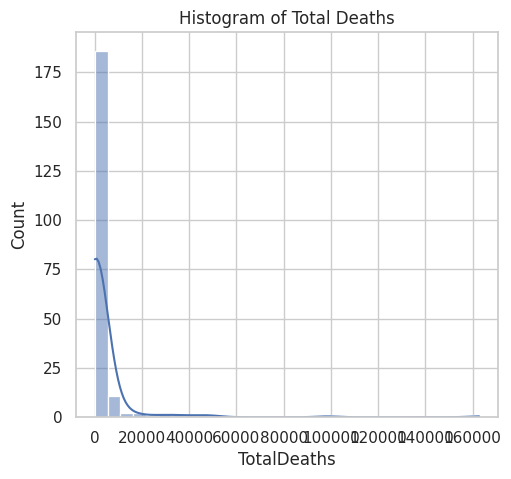

In [36]:
# Visualization 3: Histogram of Total Deaths
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_eda['TotalDeaths'], kde=True, bins=30)
plt.title('Histogram of Total Deaths')

Saved 'total_deaths_histogram.png'


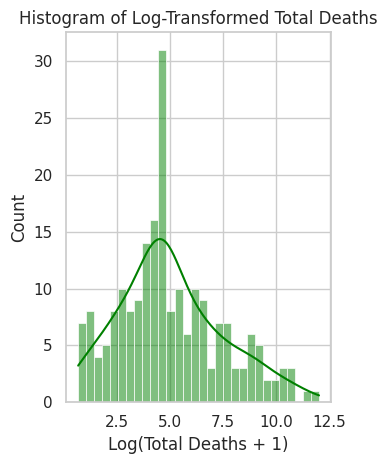

In [41]:
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_eda['TotalDeaths']), kde=True, bins=30, color='green')
plt.title('Histogram of Log-Transformed Total Deaths')
plt.xlabel('Log(Total Deaths + 1)')
plt.tight_layout()
plt.savefig('total_deaths_histogram.png')
print("Saved 'total_deaths_histogram.png'")

In [42]:
# Visualization 4: Top 15 Countries by Total Deaths
df_world_with_names = pd.read_csv('worldometer_data.csv')
df_world_with_names['TotalDeaths'] = df_world_with_names['TotalDeaths'].fillna(0)
top_15_deaths = df_world_with_names.nlargest(15, 'TotalDeaths')

Saved 'top_15_countries_by_deaths.png'


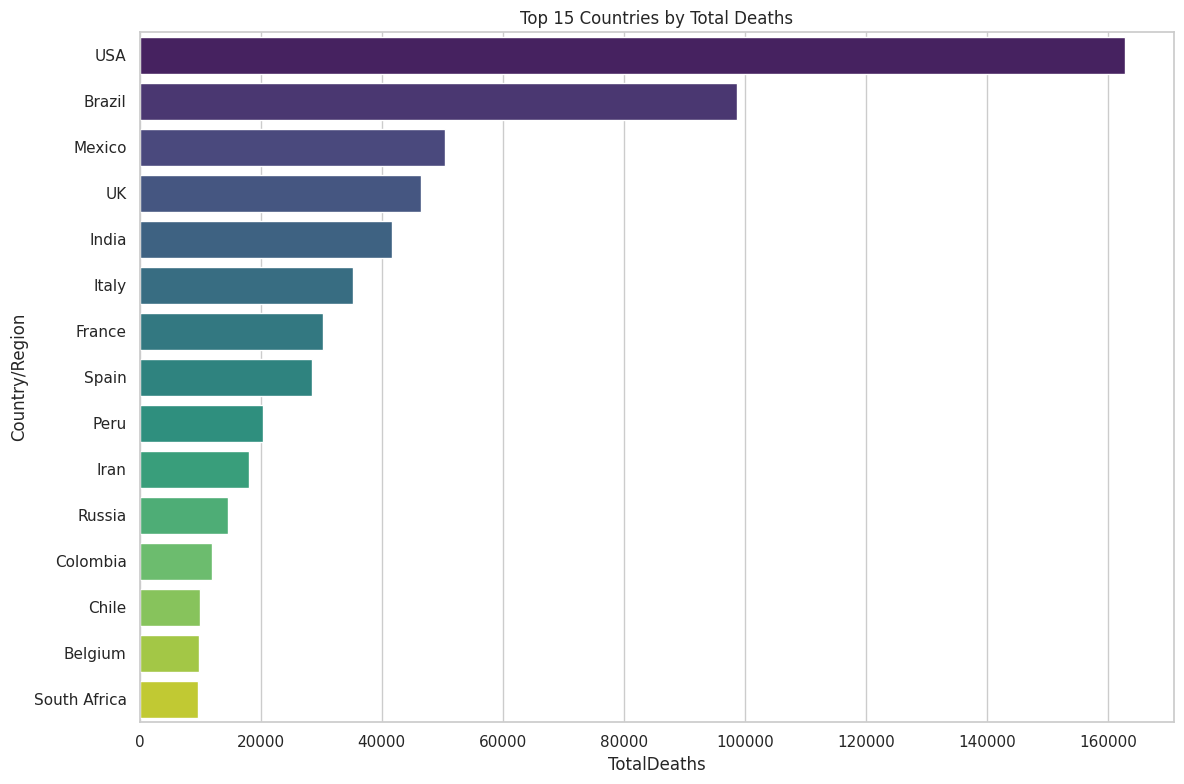

In [43]:
plt.figure(figsize=(12, 8))
sns.barplot(data=top_15_deaths, y='Country/Region', x='TotalDeaths', palette='viridis')
plt.title('Top 15 Countries by Total Deaths')
plt.tight_layout()
plt.savefig('top_15_countries_by_deaths.png')
print("Saved 'top_15_countries_by_deaths.png'")

Saved 'correlation_heatmap.png'


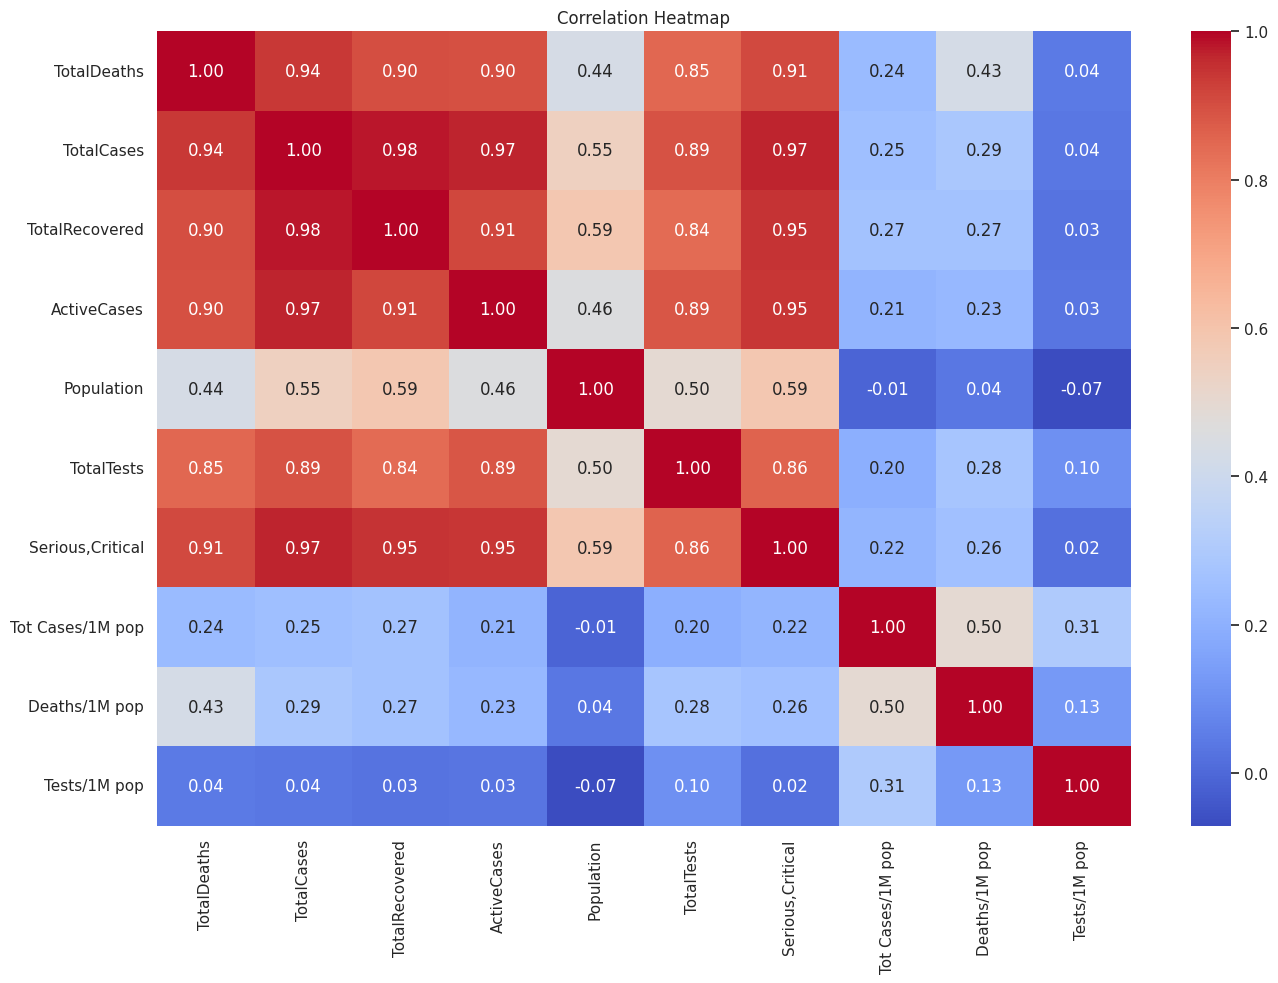

In [44]:
# Visualization 5: Correlation Heatmap
plt.figure(figsize=(14, 10))
corr_cols = ['TotalDeaths', 'TotalCases', 'TotalRecovered', 'ActiveCases', 'Population', 'TotalTests', 'Serious,Critical', 'Tot Cases/1M pop', 'Deaths/1M pop', 'Tests/1M pop']
corr_matrix = df_eda[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
print("Saved 'correlation_heatmap.png'")

In [45]:
# --- Model Building ---
print("Building predictive model...")

# Create the full model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

Building predictive model...


In [46]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples.")

# Train model
model_pipeline.fit(X_train, y_train)
print("Model trained successfully.")

# Evaluate model
y_pred = model_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

Training on 167 samples, testing on 42 samples.
Model trained successfully.


In [47]:
print(f"\n--- Model Evaluation ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")

# --- Feature Importance ---
print("Extracting feature importance...")

# Get feature names from the preprocessor
ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(numeric_features) + list(ohe_feature_names)

# Get importances from the model
importances = model_pipeline.named_steps['regressor'].feature_importances_


--- Model Evaluation ---
R-squared (R²): 0.7465
Mean Absolute Error (MAE): 1,290.35
Extracting feature importance...


In [48]:
# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))


Top 10 Most Important Features:
                    Feature  Importance
1                TotalCases    0.292106
2            TotalRecovered    0.159575
4          Serious,Critical    0.154631
3               ActiveCases    0.146298
7                TotalTests    0.134143
5          Tot Cases/1M pop    0.032328
6             Deaths/1M pop    0.029247
0                Population    0.025549
8              Tests/1M pop    0.007581
13  Continent_North America    0.007309


Saved 'feature_importance.png'


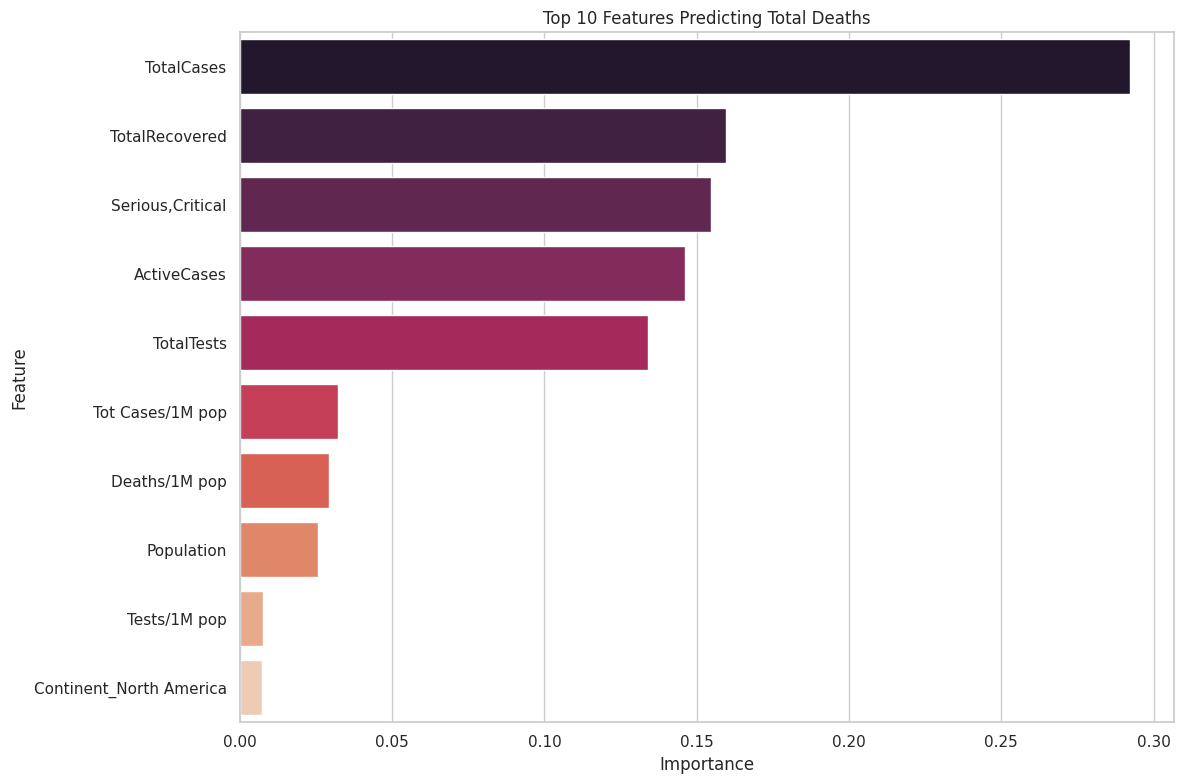

In [49]:
# Visualization 6: Feature Importance Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='rocket')
plt.title('Top 10 Features Predicting Total Deaths')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("Saved 'feature_importance.png'")

In [50]:
# -------------------------------------------------------------------
# PART 3: GEOGRAPHICAL ANALYSIS (covid_19_clean_complete.csv)
# -------------------------------------------------------------------
print("\n--- PART 3: GEOGRAPHICAL ANALYSIS ---")
print("Generating interactive map...")

# Preprocessing
df_clean_complete['Date'] = pd.to_datetime(df_clean_complete['Date'])

# Find latest date
latest_date = df_clean_complete['Date'].max()
print(f"Filtering data for latest date: {latest_date.date()}")
df_latest = df_clean_complete[df_clean_complete['Date'] == latest_date]


--- PART 3: GEOGRAPHICAL ANALYSIS ---
Generating interactive map...
Filtering data for latest date: 2020-07-27


In [53]:
# Group by country to avoid province-level duplicates for a world map
df_map = df_latest.groupby('Country/Region').agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Lat': 'mean',
    'Long': 'mean'
}).reset_index()

# Create interactive map with Plotly
fig = px.scatter_geo(df_map,
                     lat='Lat',
                     lon='Long',
                     size='Confirmed',
                     color='Deaths',
                     hover_name='Country/Region',
                     size_max=50,
                     template='plotly_dark',
                     color_continuous_scale=px.colors.sequential.YlOrRd,
                     title=f'COVID-19 Confirmed Cases (size) and Deaths (color) as of {latest_date.date()}')

In [54]:
# Save as HTML (you can open this file in Colab)
fig.write_html("global_covid_map.html")
print("Saved 'global_covid_map.html'")

# -------------------------------------------------------------------
# PROJECT COMPLETE
# -------------------------------------------------------------------
print("\n--- PROJECT COMPLETE ---")
print("All analyses are complete. Check the output for 6 saved plot images and 1 interactive HTML map file.")

Saved 'global_covid_map.html'

--- PROJECT COMPLETE ---
All analyses are complete. Check the output for 6 saved plot images and 1 interactive HTML map file.
